## Task: Prepare Modelling data from the formatted datasets

In [51]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from statistics import mode, median
import pickle
import os

from factslab.utility import load_glove_embedding
from factslab.datastructures import ConstituencyTree, DependencyTree
from factslab.pytorch.childsumtreelstm import *
#from pytorch.rnnregression import RNNRegressionTrainer
from factslab.pytorch.rnnregression import RNNRegression

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import itertools

##Torch
import torch
from torch.nn import MSELoss, L1Loss, SmoothL1Loss, CrossEntropyLoss

#### Formatted datasets location

In [2]:
home_dir = "/Users"

In [47]:
data_path = "../data/"
ud_trees = home_dir + "/sidvash/Dropbox/facts_lab/UD_data_trees/structures.tsv"
train_file_p1 = "bulk_data_temporal_duration.csv"

#Taken from github - includes doc ids and sent ids
ud_train_detailed =  home_dir +"/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-train.conllu"
ud_dev_detailed =  home_dir +"/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-dev.conllu"
ud_test_detailed = home_dir + "/sidvash/Dropbox/facts_lab/veridicality_sid/UD_English/en_ewt-ud-test.conllu"

## Structures object

In [46]:
ud_trees = home_dir +"/sidvash/Dropbox/facts_lab/UD_data_trees/structures.tsv"

struct_dict = {}

with open(ud_trees, 'r') as f:
    structs_sents = [line.strip().split('\t') for line in f]

for sent_id, tree_list, sent in structs_sents:
    struct_dict[sent_id] = DependencyTree.fromstring(tree_list)
    struct_dict[sent_id].sentence = sent.split(" ")
    
print(struct_dict['en-ud-dev.conllu sent_1'].sentence)

['From', 'the', 'AP', 'comes', 'this', 'story', ':']


## Load Data

In [4]:
data_p1 = pd.read_csv(data_path + train_file_p1)

In [5]:
cols = ["split", "worker_id", "sent_token", "sentence_id_1", "sentence_id_2", "sentence", "pred1_text", "pred2_text",
        "pred1_token", "pred2_token", "pred1_root_token", "pred2_root_token", 
       "pred1_duration", "pred2_duration", "pred1_slider", "pred2_slider",
       "pred1_dur_conf", "pred2_dur_conf", "relation_conf", "doc_id"]

out_data = data_p1[cols]

out_data['sent_pred_id1'] = out_data['sentence_id_1'] + " " + out_data['pred1_root_token'].map(lambda x: str(x))
out_data['sent_pred_id2'] = out_data['sentence_id_2'] + " " + out_data['pred2_root_token'].map(lambda x: str(x))

#out_data.head()

## Pre-Process Data

### 1.1 Remove empty slider positions

In [6]:
print(out_data.shape)
out_data = out_data[(out_data.pred1_slider!="{}") &
                   (out_data.pred2_slider!="{}")]
print(out_data.shape)

(85125, 22)
(85124, 22)


### 1.2 Get the slider-values into lists

In [7]:
out_data['pred1_slider_lst'] = out_data['pred1_slider'].map(lambda x: [int(item) for item in x.split("-")])
out_data['pred2_slider_lst'] = out_data['pred2_slider'].map(lambda x: [int(item) for item in x.split("-")])

###  1.3 TIME_ML tags

In [8]:
def time_ml_tag(row, var1, var2):
    '''
    Creates time ML tags from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relations: is before
    '''
    ans = ""
    event1 = getattr(row, var1)
    event2 = getattr(row, var2)
    
    if (event1[0] == event2[0]) and (event1[1] == event2[1]):
        ans = "simultaneous"
    elif event1[1] <= event2[0]:
        ans = "before"
    
    elif event1[0] >= event2[1]:
        ans = "after"
        
    elif event1[1] >= event2[1] and event1[0] <= event2[0]:
        ans = "includes"
        
    elif event1[1] <= event2[1] and event1[0] >= event2[0]:
        ans = "is_included"
    
    elif event1[0] < event2[0] and event1[1] > event2[0]:
        ans = "before_cont"
        
    elif event1[0] < event2[1] and event1[1] > event2[1]:
        ans = "after_cont"
    else: 
        ans = "other"
    return ans

In [9]:
out_data['time_ml'] = out_data.apply(lambda row: time_ml_tag(row, 
                                                             'pred1_slider_lst', 
                                                             'pred2_slider_lst'),
                                    axis=1)
out_data['time_ml'] = out_data['time_ml'].astype('category')
out_data['time_ml_code'] = out_data['time_ml'].cat.codes

print(out_data['time_ml'].cat.categories)

#out_data.head()

Index(['after', 'after_cont', 'before', 'before_cont', 'includes',
       'is_included', 'simultaneous'],
      dtype='object')


### 1.4 Normalize slider Values

In [10]:
def normalize_sliders(row, var_s1, var_s2,
                     param="slider1"):
    '''
    Input:
    var_min_slider: name of the variable having min slider value
    var_max_slider: name of the variable having max slider value
    var_s1: name of the variable having slider1 values
    var_s1: name of the variable having slider2 values
    
    Output:
    norm_slider1: normalized slider1 values
    norm_slider2: normalized slider2 values
    '''
    b1, e1 = getattr(row, var_s1)
    b2, e2 = getattr(row, var_s2)
    
    min_val = min(b1,e1,b2,e2)
    max_val = max(b1,e1,b2,e2)
    
    if param=="slider1":
        try:
            return [round((b1-min_val)/max_val,4), round((e1-min_val)/max_val, 4)]
        except:
            return [0,0]
    else:
        try:
            return [round((b2-min_val)/max_val,4), round((e2-min_val)/max_val,4)]
        except:
            return [0,0]

In [11]:
out_data['norm_slider1'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider1"), axis=1)
out_data['norm_slider2'] = out_data.apply(lambda row: normalize_sliders(row, "pred1_slider_lst", 
                                                                        "pred2_slider_lst",
                                                                        param="slider2"), axis=1)
out_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,relation_conf,doc_id,sent_pred_id1,sent_pred_id2,pred1_slider_lst,pred2_slider_lst,time_ml,time_ml_code,norm_slider1,norm_slider2
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,4,10,en-ud-train.conllu 418 17,en-ud-train.conllu 418 19,"[35, 41]","[64, 65]",before,2,"[0.0, 0.0923]","[0.4462, 0.4615]"
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,4,189,en-ud-train.conllu 9490 51,en-ud-train.conllu 9490 53,"[0, 65]","[0, 65]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,4,83,en-ud-train.conllu 7143 8,en-ud-train.conllu 7144 14,"[0, 81]","[0, 81]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]"
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,4,126,en-ud-train.conllu 7786 17,en-ud-train.conllu 7787 9,"[35, 44]","[0, 100]",is_included,5,"[0.35, 0.44]","[0.0, 1.0]"
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,4,65,en-ud-train.conllu 5729 4,en-ud-train.conllu 5729 36,"[36, 42]","[0, 26]",after,0,"[0.8571, 1.0]","[0.0, 0.619]"


## Extract Timelines

In [12]:
device=torch.device(type="cpu")

class TimelineModel(torch.nn.Module):
    '''
     A class to extract a simple timeline model from a
     given document's predicate-pair data
    '''
    def __init__(self,
                 data = None,
                 num_preds = None,
                 optimizer_class = torch.optim.Adam,
                device=torch.device(type="cpu") ,
                **kwargs):
        super().__init__()

        self.device = device
        self.fine_loss = L1Loss().to(self.device)
        
        self.pred_tensor = torch.nn.Parameter(torch.randn(num_preds,2))
        self._optimizer_class = optimizer_class

    def forward(self, local_data, **kwargs):
        '''
        INput: dataframe with cols:
                b1, e1, b2, e2, pred1_dict_idx, pred2_dict_idx
                
        Output: 
        '''
        t_sq = self.pred_tensor**2 
        
        num_preds= t_sq.size()[0]
        anchored_tensor = torch.zeros(num_preds,2)
        
        anchored_tensor[:,0] = t_sq[:,0] - t_sq[:,0].min()
        anchored_tensor[:,1] = t_sq[:,1]
        
        #Predicted values
        b1 = anchored_tensor[local_data.pred1_dict_idx.values][:,0]
        dur1 = anchored_tensor[local_data.pred1_dict_idx.values][:,1]
        b2 = anchored_tensor[local_data.pred2_dict_idx.values][:,0]
        dur2 = anchored_tensor[local_data.pred2_dict_idx.values][:,1]
        
        return b1, dur1, b2, dur2, anchored_tensor
    
    def fit(self, local_data, epochs=100, **kwargs):
        losses = [10000]
        
        print("#### Model Parameters ####")
        for name,param in self.named_parameters():     
            if param.requires_grad:
                print(name, param.shape) 
        print("##########################") 
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = self._optimizer_class(parameters)
        
        #Actual values
        b1_lst = local_data.b1.values
        e1_lst = local_data.e1.values
        b2_lst = local_data.b2.values
        e2_lst = local_data.e2.values
        
        actuals = self._lsts_to_tensors(b1_lst, e1_lst, b2_lst, e2_lst,
                                        param="float")
        
        for epoch in range(epochs):
            
            preds = self.forward(local_data)
            #zero_grad
            optimizer.zero_grad()
            curr_loss = self._custom_loss(preds, actuals)
            curr_loss.backward()
            optimizer.step()
            
            if epoch==0:
                print("Epoch: {}, Initial-Loss: {}".format(epoch+1, curr_loss))
               
            ## Stop training when loss converges
            if abs(curr_loss.detach() - losses[-1]) < 0.00001:
                print("Epoch: {}, Converging-Loss: {}".format(epoch+1, curr_loss))
                break
                
            losses.append(curr_loss.detach())
                
        return self.predict(preds)
        
    def _custom_loss(self, preds, actuals):
    
        b1_pred, dur1_pred, b2_pred, dur2_pred, _ = preds
        b1_act, e1_act, b2_act, e2_act = actuals
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = t/t_max.view(num_pairs,1)
        
        ## Fine-grained Losses
        l1 = self.fine_loss(t[:,0]-t[:,2], b1_act-b2_act)
        l2 = self.fine_loss(t[:,1]-t[:,2], e1_act-b2_act)
        l3 = self.fine_loss(t[:,3]-t[:,0], e2_act-b1_act)
        l4 = self.fine_loss(t[:,1]-t[:,3], e1_act-e2_act)
        
        a,b,c,d=0.25,0.25,0.25, 0.25 
        total_loss1 = a*l1+ b*l2+ c*l3+ d*l4
        
        ## match exact
#         l5 = self.fine_loss(t[:,0], b1_act)
#         l6 = self.fine_loss(t[:,1], e1_act)
#         l7 = self.fine_loss(t[:,2], b2_act)
#         l8 = self.fine_loss(t[:,3], e2_act)
    
#         total_loss2 = (l5+l6+l7+l8)/4
        
        return total_loss1
        
    def _lsts_to_tensors(self, *args, param=None):
        '''
        Input: list1, list2,......

        Output: [Tensor(list1), tensor(list2),....]

        '''
        if param=="float":
            return [torch.from_numpy(np.array(arg)).float().to(self.device) for arg in args]
        else:
            return [torch.from_numpy(np.array(arg, dtype="int64")).to(self.device) for arg in args]
        
    def predict(self, preds):
        b1_pred, dur1_pred, b2_pred, dur2_pred, pred_timeline = preds
        
        ## Normalize predicted values:
        num_pairs = b1_pred.size()[0]
        t = torch.zeros(num_pairs,4)
        t[:,0] = b1_pred
        t[:,1] = b1_pred + dur1_pred
        t[:,2] = b2_pred
        t[:,3] = b2_pred + dur2_pred
        t_min, _ = torch.min(t,dim=1)
        t_max, _ = torch.max(t,dim=1)
        t = t - t_min.view(num_pairs,1)
        t = (t/t_max.view(num_pairs,1)).detach().numpy()
        

        return t[:,0],t[:,1], t[:,2], t[:,3], pred_timeline.detach().numpy()
        

In [13]:
def extract_preds(doc_id, data, split_data="train"):
    '''
    Extracts a dict of predicates for a given docid and data-split
    Key: pred_sent_id
    Value: predicate-index
    '''
    cols = ['sent_pred_id1', 'sent_pred_id2', 'norm_slider1', 'norm_slider2']
    
    local_data = data[(data.split==split_data) & (out_data.doc_id == doc_id)][cols]
    local_data['b1'] = local_data['norm_slider1'].map(lambda x: x[0])
    local_data['e1'] = local_data['norm_slider1'].map(lambda x: x[1])
    local_data['b2'] = local_data['norm_slider2'].map(lambda x: x[0])
    local_data['e2'] = local_data['norm_slider2'].map(lambda x: x[1])
    
    
    preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
    uniq_preds = np.unique(preds_arr.flatten())
    
    pred_dict = {}
    idx=0
    for pred in uniq_preds:
        pred_dict[pred]=idx
        idx+=1
        
    local_data['pred1_dict_idx'] = local_data['sent_pred_id1'].map(lambda x: pred_dict[x])
    local_data['pred2_dict_idx'] = local_data['sent_pred_id2'].map(lambda x: pred_dict[x])
        
    return pred_dict, idx, local_data

In [14]:
pred_dict, num_preds, local_data = extract_preds(9, out_data)
print(num_preds)
local_data.head()

150


,sent_pred_id1,sent_pred_id2,norm_slider1,norm_slider2,b1,e1,b2,e2,pred1_dict_idx,pred2_dict_idx
172,en-ud-train.conllu 350 3,en-ud-train.conllu 351 13,"[0.0, 0.2045]","[0.0, 0.5227]",0.0,0.2045,0.00,0.5227,36,38
362,en-ud-train.conllu 366 25,en-ud-train.conllu 366 34,"[0.0, 0.3]","[0.3, 0.7143]",0.0,0.3000,0.30,0.7143,56,58
381,en-ud-train.conllu 398 11,en-ud-train.conllu 398 21,"[0.0, 0.4]","[0.46, 0.84]",0.0,0.4000,0.46,0.8400,131,132
393,en-ud-train.conllu 391 17,en-ud-train.conllu 391 24,"[0.0, 1.0]","[0.0, 1.0]",0.0,1.0000,0.00,1.0000,112,113
461,en-ud-train.conllu 367 1,en-ud-train.conllu 368 6,"[0.0, 0.7237]","[0.0, 0.7237]",0.0,0.7237,0.00,0.7237,60,62


In [15]:
## Run Timeline Model on current docid's data
# model = TimelineModel(data = local_data,
#          num_preds = num_preds,
#         device=torch.device(type="cpu"))

# pred_b1, pred_e1, pred_b2, pred_e2, pred_timeline  = model.fit(local_data, epochs=100000)
# #doc_timelines[doc_id] = pred_timeline

In [16]:
def extract_predictions(data, split_data="train"):
    '''
    Extract predicted slider values and document timelines for
    a given data
    '''
    data_mod = data[data.split==split_data]
    
    doc_ids = data_mod['doc_id'].unique()
    
    doc_timelines = {}
    
    for i,doc_id in enumerate(doc_ids):
        pred_dict, num_preds, local_data = extract_preds(doc_id, data_mod, 
                                                   split_data=split_data)
        
        ## Run Timeline Model on current docid's data
        model = TimelineModel(data = local_data,
                 num_preds = num_preds,
                device=torch.device(type="cpu"))
        
        pred_b1, pred_e1, pred_b2, pred_e2, pred_timeline  = model.fit(local_data, epochs=100000)
        doc_timelines[doc_id] = pred_timeline
        
        ## Store prediction-values into the dataset
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b1'] = pred_b1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e1'] = pred_e1
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_b2'] = pred_b2
        
        data_mod.loc[(data_mod.doc_id == doc_id), 
                     'predicted_e2'] = pred_e2

        print("Documents processed: {}, Curr_docid: {}\n".format(i+1, doc_id))
        
        
    return data_mod, doc_timelines

In [17]:
train_data, train_doc_timlines = extract_predictions(out_data, split_data="train")

#### Model Parameters ####
pred_tensor torch.Size([171, 2])
##########################
Epoch: 1, Initial-Loss: 0.5858520269393921
Epoch: 2023, Converging-Loss: 0.2017635852098465
Documents processed: 1, Curr_docid: 10

#### Model Parameters ####
pred_tensor torch.Size([136, 2])
##########################
Epoch: 1, Initial-Loss: 0.5787646174430847
Epoch: 1540, Converging-Loss: 0.20140701532363892
Documents processed: 2, Curr_docid: 189

#### Model Parameters ####
pred_tensor torch.Size([309, 2])
##########################
Epoch: 1, Initial-Loss: 0.5846737623214722
Epoch: 1577, Converging-Loss: 0.1542593538761139
Documents processed: 3, Curr_docid: 83

#### Model Parameters ####
pred_tensor torch.Size([34, 2])
##########################
Epoch: 1, Initial-Loss: 0.6929934620857239
Epoch: 2002, Converging-Loss: 0.1972687840461731
Documents processed: 4, Curr_docid: 126

#### Model Parameters ####
pred_tensor torch.Size([66, 2])
##########################
Epoch: 1, Initial-Loss: 0.5936487317

Epoch: 1761, Converging-Loss: 0.2014106959104538
Documents processed: 38, Curr_docid: 80

#### Model Parameters ####
pred_tensor torch.Size([55, 2])
##########################
Epoch: 1, Initial-Loss: 0.5558071732521057
Epoch: 1204, Converging-Loss: 0.1963179111480713
Documents processed: 39, Curr_docid: 158

#### Model Parameters ####
pred_tensor torch.Size([206, 2])
##########################
Epoch: 1, Initial-Loss: 0.5674995183944702
Epoch: 1602, Converging-Loss: 0.20622538030147552
Documents processed: 40, Curr_docid: 43

#### Model Parameters ####
pred_tensor torch.Size([148, 2])
##########################
Epoch: 1, Initial-Loss: 0.564031720161438
Epoch: 1752, Converging-Loss: 0.19636675715446472
Documents processed: 41, Curr_docid: 185

#### Model Parameters ####
pred_tensor torch.Size([291, 2])
##########################
Epoch: 1, Initial-Loss: 0.5726723074913025
Epoch: 1907, Converging-Loss: 0.19491524994373322
Documents processed: 42, Curr_docid: 193

#### Model Parameters ####

Documents processed: 75, Curr_docid: 304

#### Model Parameters ####
pred_tensor torch.Size([147, 2])
##########################
Epoch: 1, Initial-Loss: 0.6177722215652466
Epoch: 1621, Converging-Loss: 0.18751153349876404
Documents processed: 76, Curr_docid: 52

#### Model Parameters ####
pred_tensor torch.Size([622, 2])
##########################
Epoch: 1, Initial-Loss: 0.5752422213554382
Epoch: 1799, Converging-Loss: 0.20191404223442078
Documents processed: 77, Curr_docid: 17

#### Model Parameters ####
pred_tensor torch.Size([87, 2])
##########################
Epoch: 1, Initial-Loss: 0.6388852000236511
Epoch: 1419, Converging-Loss: 0.20505911111831665
Documents processed: 78, Curr_docid: 19

#### Model Parameters ####
pred_tensor torch.Size([58, 2])
##########################
Epoch: 1, Initial-Loss: 0.6181132197380066
Epoch: 2014, Converging-Loss: 0.20234383642673492
Documents processed: 79, Curr_docid: 169

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
################

Epoch: 1499, Converging-Loss: 0.1950364112854004
Documents processed: 113, Curr_docid: 170

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6311633586883545
Epoch: 1351, Converging-Loss: 0.15940605103969574
Documents processed: 114, Curr_docid: 388

#### Model Parameters ####
pred_tensor torch.Size([51, 2])
##########################
Epoch: 1, Initial-Loss: 0.4868156313896179
Epoch: 1076, Converging-Loss: 0.19660145044326782
Documents processed: 115, Curr_docid: 522

#### Model Parameters ####
pred_tensor torch.Size([57, 2])
##########################
Epoch: 1, Initial-Loss: 0.5398631691932678
Epoch: 1491, Converging-Loss: 0.16536222398281097
Documents processed: 116, Curr_docid: 529

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5245668888092041
Epoch: 1526, Converging-Loss: 0.17136035859584808
Documents processed: 117, Curr_docid: 507

#### Model Parameters

Documents processed: 150, Curr_docid: 20

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.5901147127151489
Epoch: 2004, Converging-Loss: 0.16142521798610687
Documents processed: 151, Curr_docid: 488

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.48906826972961426
Epoch: 1522, Converging-Loss: 0.1796189248561859
Documents processed: 152, Curr_docid: 394

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.5958691835403442
Epoch: 1402, Converging-Loss: 0.23319387435913086
Documents processed: 153, Curr_docid: 510

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.6581941843032837
Epoch: 1491, Converging-Loss: 0.22906193137168884
Documents processed: 154, Curr_docid: 498

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
###########

Documents processed: 187, Curr_docid: 453

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.5528789758682251
Epoch: 1117, Converging-Loss: 0.2182024121284485
Documents processed: 188, Curr_docid: 210

#### Model Parameters ####
pred_tensor torch.Size([138, 2])
##########################
Epoch: 1, Initial-Loss: 0.5291398763656616
Epoch: 1306, Converging-Loss: 0.21620917320251465
Documents processed: 189, Curr_docid: 8

#### Model Parameters ####
pred_tensor torch.Size([22, 2])
##########################
Epoch: 1, Initial-Loss: 0.5229963064193726
Epoch: 916, Converging-Loss: 0.23398888111114502
Documents processed: 190, Curr_docid: 472

#### Model Parameters ####
pred_tensor torch.Size([59, 2])
##########################
Epoch: 1, Initial-Loss: 0.5956287980079651
Epoch: 1483, Converging-Loss: 0.19102069735527039
Documents processed: 191, Curr_docid: 151

#### Model Parameters ####
pred_tensor torch.Size([27, 2])
##############

Epoch: 1249, Converging-Loss: 0.19837665557861328
Documents processed: 225, Curr_docid: 124

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.613499641418457
Epoch: 1497, Converging-Loss: 0.24101895093917847
Documents processed: 226, Curr_docid: 505

#### Model Parameters ####
pred_tensor torch.Size([25, 2])
##########################
Epoch: 1, Initial-Loss: 0.5658708810806274
Epoch: 1343, Converging-Loss: 0.19214990735054016
Documents processed: 227, Curr_docid: 462

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5812022089958191
Epoch: 1305, Converging-Loss: 0.17499487102031708
Documents processed: 228, Curr_docid: 392

#### Model Parameters ####
pred_tensor torch.Size([78, 2])
##########################
Epoch: 1, Initial-Loss: 0.5180603265762329
Epoch: 1552, Converging-Loss: 0.1520482301712036
Documents processed: 229, Curr_docid: 60

#### Model Parameters 

Documents processed: 262, Curr_docid: 305

#### Model Parameters ####
pred_tensor torch.Size([28, 2])
##########################
Epoch: 1, Initial-Loss: 0.5546950101852417
Epoch: 1442, Converging-Loss: 0.1846054494380951
Documents processed: 263, Curr_docid: 114

#### Model Parameters ####
pred_tensor torch.Size([30, 2])
##########################
Epoch: 1, Initial-Loss: 0.5445929765701294
Epoch: 1328, Converging-Loss: 0.195762500166893
Documents processed: 264, Curr_docid: 494

#### Model Parameters ####
pred_tensor torch.Size([26, 2])
##########################
Epoch: 1, Initial-Loss: 0.584783136844635
Epoch: 887, Converging-Loss: 0.22758172452449799
Documents processed: 265, Curr_docid: 473

#### Model Parameters ####
pred_tensor torch.Size([32, 2])
##########################
Epoch: 1, Initial-Loss: 0.5755449533462524
Epoch: 1096, Converging-Loss: 0.22774000465869904
Documents processed: 266, Curr_docid: 500

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
################

Epoch: 1977, Converging-Loss: 0.18535734713077545
Documents processed: 300, Curr_docid: 413

#### Model Parameters ####
pred_tensor torch.Size([65, 2])
##########################
Epoch: 1, Initial-Loss: 0.5758817195892334
Epoch: 1173, Converging-Loss: 0.1806933432817459
Documents processed: 301, Curr_docid: 171

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.590512752532959
Epoch: 1279, Converging-Loss: 0.20817121863365173
Documents processed: 302, Curr_docid: 228

#### Model Parameters ####
pred_tensor torch.Size([31, 2])
##########################
Epoch: 1, Initial-Loss: 0.6688788533210754
Epoch: 1597, Converging-Loss: 0.2588461637496948
Documents processed: 303, Curr_docid: 110

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.7119617462158203
Epoch: 1314, Converging-Loss: 0.19895505905151367
Documents processed: 304, Curr_docid: 268

#### Model Parameters 

Documents processed: 337, Curr_docid: 21

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.4709628224372864
Epoch: 825, Converging-Loss: 0.24363553524017334
Documents processed: 338, Curr_docid: 246

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.5279358625411987
Epoch: 1895, Converging-Loss: 0.16286998987197876
Documents processed: 339, Curr_docid: 432

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.5415474772453308
Epoch: 1554, Converging-Loss: 0.20634973049163818
Documents processed: 340, Curr_docid: 422

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.4487765431404114
Epoch: 388, Converging-Loss: 0.16202187538146973
Documents processed: 341, Curr_docid: 285

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
#############

Epoch: 787, Converging-Loss: 0.16542482376098633
Documents processed: 375, Curr_docid: 416

#### Model Parameters ####
pred_tensor torch.Size([36, 2])
##########################
Epoch: 1, Initial-Loss: 0.6212950348854065
Epoch: 1526, Converging-Loss: 0.23112978041172028
Documents processed: 376, Curr_docid: 116

#### Model Parameters ####
pred_tensor torch.Size([20, 2])
##########################
Epoch: 1, Initial-Loss: 0.49425095319747925
Epoch: 1340, Converging-Loss: 0.18867556750774384
Documents processed: 377, Curr_docid: 404

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.47672954201698303
Epoch: 738, Converging-Loss: 0.15759479999542236
Documents processed: 378, Curr_docid: 306

#### Model Parameters ####
pred_tensor torch.Size([17, 2])
##########################
Epoch: 1, Initial-Loss: 0.5216729640960693
Epoch: 1696, Converging-Loss: 0.17107564210891724
Documents processed: 379, Curr_docid: 393

#### Model Parameter

Epoch: 1195, Converging-Loss: 0.14410048723220825
Documents processed: 412, Curr_docid: 293

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.5924406051635742
Epoch: 929, Converging-Loss: 0.1853482723236084
Documents processed: 413, Curr_docid: 333

#### Model Parameters ####
pred_tensor torch.Size([23, 2])
##########################
Epoch: 1, Initial-Loss: 0.5965022444725037
Epoch: 1891, Converging-Loss: 0.19009894132614136
Documents processed: 414, Curr_docid: 454

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.5348377823829651
Epoch: 1138, Converging-Loss: 0.11925213038921356
Documents processed: 415, Curr_docid: 434

#### Model Parameters ####
pred_tensor torch.Size([11, 2])
##########################
Epoch: 1, Initial-Loss: 0.7000437378883362
Epoch: 1557, Converging-Loss: 0.21018335223197937
Documents processed: 416, Curr_docid: 331

#### Model Parameters

Documents processed: 449, Curr_docid: 155

#### Model Parameters ####
pred_tensor torch.Size([18, 2])
##########################
Epoch: 1, Initial-Loss: 0.5685529708862305
Epoch: 896, Converging-Loss: 0.21600043773651123
Documents processed: 450, Curr_docid: 424

#### Model Parameters ####
pred_tensor torch.Size([13, 2])
##########################
Epoch: 1, Initial-Loss: 0.6343380212783813
Epoch: 1176, Converging-Loss: 0.16995105147361755
Documents processed: 451, Curr_docid: 299

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5355501174926758
Epoch: 948, Converging-Loss: 0.1787983626127243
Documents processed: 452, Curr_docid: 400

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##########################
Epoch: 1, Initial-Loss: 0.5990530848503113
Epoch: 1134, Converging-Loss: 0.12070140242576599
Documents processed: 453, Curr_docid: 478

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##############

Epoch: 1137, Converging-Loss: 0.13333870470523834
Documents processed: 487, Curr_docid: 204

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.46913430094718933
Epoch: 780, Converging-Loss: 0.23566293716430664
Documents processed: 488, Curr_docid: 212

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.8068742752075195
Epoch: 1368, Converging-Loss: 0.21615877747535706
Documents processed: 489, Curr_docid: 248

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.4560106098651886
Epoch: 1141, Converging-Loss: 0.18286970257759094
Documents processed: 490, Curr_docid: 217

#### Model Parameters ####
pred_tensor torch.Size([16, 2])
##########################
Epoch: 1, Initial-Loss: 0.5382200479507446
Epoch: 689, Converging-Loss: 0.15797728300094604
Documents processed: 491, Curr_docid: 460

#### Model Parameters 

Documents processed: 524, Curr_docid: 239

#### Model Parameters ####
pred_tensor torch.Size([7, 2])
##########################
Epoch: 1, Initial-Loss: 0.5930014848709106
Epoch: 462, Converging-Loss: 0.28581976890563965
Documents processed: 525, Curr_docid: 291

#### Model Parameters ####
pred_tensor torch.Size([9, 2])
##########################
Epoch: 1, Initial-Loss: 0.6726362109184265
Epoch: 956, Converging-Loss: 0.1467733383178711
Documents processed: 526, Curr_docid: 221

#### Model Parameters ####
pred_tensor torch.Size([10, 2])
##########################
Epoch: 1, Initial-Loss: 0.4956103563308716
Epoch: 609, Converging-Loss: 0.1680268943309784
Documents processed: 527, Curr_docid: 207

#### Model Parameters ####
pred_tensor torch.Size([8, 2])
##########################
Epoch: 1, Initial-Loss: 0.6007341146469116
Epoch: 1307, Converging-Loss: 0.12933029234409332
Documents processed: 528, Curr_docid: 234

#### Model Parameters ####
pred_tensor torch.Size([14, 2])
##################

In [18]:
train_data['predicted_slider1'] = train_data.apply(lambda row: [round(row.predicted_b1,4) , 
                                                                round(row.predicted_e1,4)], axis=1)
train_data['predicted_slider2'] = train_data.apply(lambda row: [round(row.predicted_b2,4), 
                                                                round(row.predicted_e2,4)], axis=1)
train_data['predicted_timeml'] = train_data.apply(lambda row: time_ml_tag(row, 
                                                             'predicted_slider1', 
                                                             'predicted_slider2'),
                                                                    axis=1)
train_data.drop(['predicted_b1','predicted_e1', 'predicted_b2',  'predicted_e2'],axis=1, inplace=True)
train_data.head()

,split,worker_id,sent_token,sentence_id_1,sentence_id_2,sentence,pred1_text,pred2_text,pred1_token,pred2_token,...,sent_pred_id2,pred1_slider_lst,pred2_slider_lst,time_ml,time_ml_code,norm_slider1,norm_slider2,predicted_slider1,predicted_slider2,predicted_timeml
0,train,212,en-ud-train.conllu 418_17 en-ud-train.conllu 4...,en-ud-train.conllu 418,en-ud-train.conllu 418,Again there is no official written statement f...,think,is intentional,17,18_19,...,en-ud-train.conllu 418 19,"[35, 41]","[64, 65]",before,2,"[0.0, 0.0923]","[0.4462, 0.4615]","[0.0, 0.201]","[0.0766, 0.279]",before_cont
1,train,212,en-ud-train.conllu 9490_51 en-ud-train.conllu ...,en-ud-train.conllu 9490,en-ud-train.conllu 9490,Crowds are at their thinnest &#44; but many of...,grey,dark,51,53,...,en-ud-train.conllu 9490 53,"[0, 65]","[0, 65]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]","[0.101, 0.8564]","[0.0, 0.8388]",after_cont
2,train,212,en-ud-train.conllu 7143_8 en-ud-train.conllu 7...,en-ud-train.conllu 7143,en-ud-train.conllu 7144,1&#44;200 - Number of public - diplomacy offic...,employed,be the greatest threats to...,8,11_12_13_14_15_18_19,...,en-ud-train.conllu 7144 14,"[0, 81]","[0, 81]",simultaneous,6,"[0.0, 1.0]","[0.0, 1.0]","[0.0435, 0.7728]","[0.0, 0.7729]",is_included
3,train,212,en-ud-train.conllu 7786_17 en-ud-train.conllu ...,en-ud-train.conllu 7786,en-ud-train.conllu 7787,If you &#39;re going to go through the trouble...,getting,is a good nano protein...,17,4_5_6_7_8_9,...,en-ud-train.conllu 7787 9,"[35, 44]","[0, 100]",is_included,5,"[0.35, 0.44]","[0.0, 1.0]","[0.3203, 0.44]","[0.0, 0.9709]",is_included
4,train,212,en-ud-train.conllu 5729_4 en-ud-train.conllu 5...,en-ud-train.conllu 5729,en-ud-train.conllu 5729,My partners and I solicit your assistance in c...,solicit,served,4,36,...,en-ud-train.conllu 5729 36,"[36, 42]","[0, 26]",after,0,"[0.8571, 1.0]","[0.0, 0.619]","[0.769, 0.9117]","[0.0, 0.5301]",after


## Relations Change Statistics

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [20]:
match = sum(train_data['time_ml'] == train_data['predicted_timeml'])
total = train_data.shape[0]
print("% of Relations remained same: {}".format(match/total))

% of Relations remained same: 0.4614728250788351


before          17357
includes        11058
is_included      8899
before_cont      5865
simultaneous     5734
after            4080
after_cont        917
Name: time_ml, dtype: int64


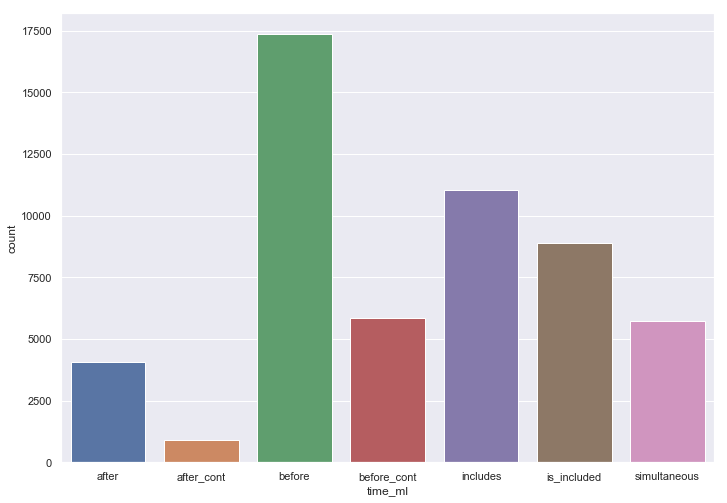

In [21]:
print(train_data.time_ml.value_counts())
sns.countplot(x='time_ml', data=train_data)
plt.show()

before_cont     15899
before          10222
includes         9919
is_included      9666
after_cont       5648
after            2554
simultaneous        2
Name: predicted_timeml, dtype: int64


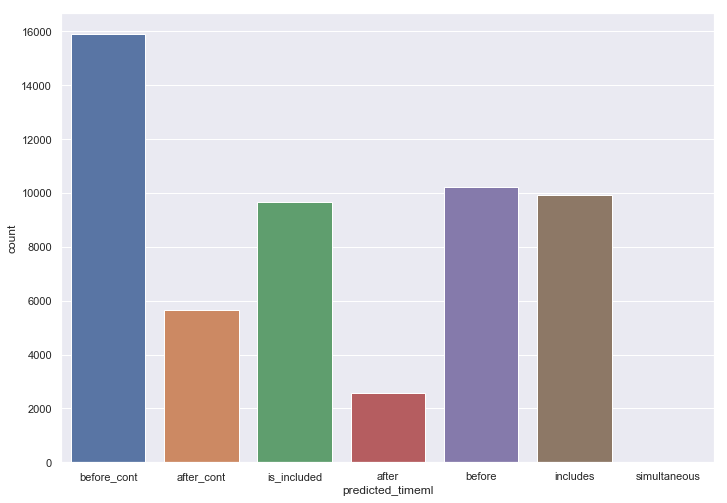

In [22]:
print(train_data.predicted_timeml.value_counts())
sns.countplot(x='predicted_timeml', data=train_data)
plt.show()

## Confusion Matrix

In [23]:
time_tags = train_data.time_ml.unique()
time_tags


[before, simultaneous, is_included, after, includes, before_cont, after_cont]
Categories (7, object): [before, simultaneous, is_included, after, includes, before_cont, after_cont]

In [24]:
conf_matrix = confusion_matrix(train_data.time_ml, train_data.predicted_timeml, labels=time_tags)

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[8324    0 1685  201 1029 5664  454]
 [ 205    2 1217   98 1388 1700 1124]
 [ 367    0 4847  159  490 2034 1002]
 [ 129    0  339 1752  456  278 1126]
 [ 553    0  649  198 5862 2574 1222]
 [ 617    0  819   79  531 3595  224]
 [  27    0  110   67  163   54  496]]


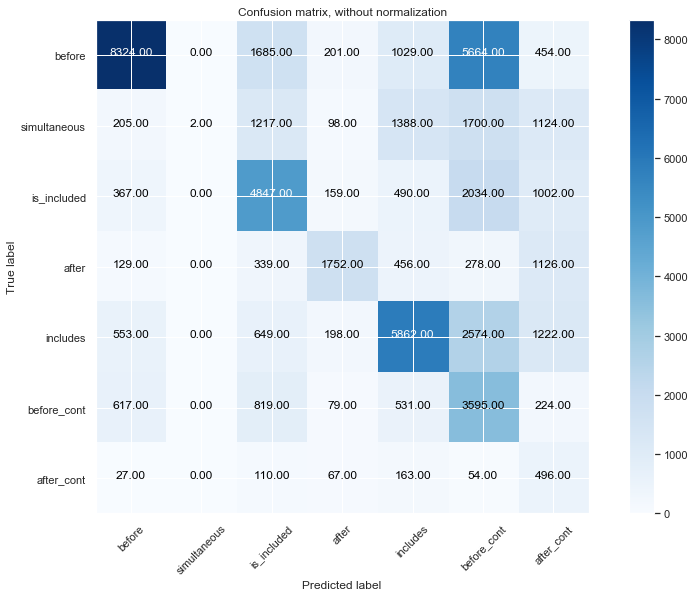

In [26]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=time_tags, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()


## Document Timeline - Example

In [66]:
def extract_pred_text(lst, data):
    '''
    Input: A list of sent_pred tokens
    Output: A list of predicate text
    '''
    ans = []
    for sent_pred in lst:
        try:
            pred_text = data[(data.sent_pred_id1==sent_pred)]['pred1_text'].values[0]
            ans.append(pred_text)
        except:
            pred_text = data[(data.sent_pred_id2==sent_pred)]['pred2_text'].values[0]
            ans.append(pred_text)
            
    return ans

def extract_timeline_df(docid, data):
    '''
    Extract a timeline_df for a given docid and data
    '''
    cols = ['sent_pred_id1', 'sent_pred_id2', 'pred1_text', 'pred2_text',
            'doc_id', 'norm_slider1', 'norm_slider2']
    
    local_data = data[(data.doc_id == docid)][cols]
    preds_arr = local_data[['sent_pred_id1', 'sent_pred_id2']].values
    uniq_preds = np.unique(preds_arr.flatten())
    #print(uniq_preds)
    
    preds_text = extract_pred_text(uniq_preds, local_data)
    
    ans_df = pd.DataFrame(data=train_doc_timlines[docid], 
                         columns=['start_pt', 'duration'])
    ans_df['sent_pred_id'] = uniq_preds
    ans_df['pred_text'] = preds_text
    ans_df['doc_id'] = docid
    
    return ans_df

def load_ud_english(fpath):
    """Load a file from the UD English corpus

    Parameters
    ----------
    fpath : str
        Path to UD corpus file ending in .conllu
        
    Output: Returns a list equal to length of total num of docs
            with each item contaiing the first index of sentence
            in that doc
    """

    n = 1

    fname = os.path.split(fpath)[1]

    parses = defaultdict(list)
    sent_ids = []
    newdoc_ids = []
    
    for l in open(fpath):
        ident = fname+' '+str(n)
        
        if re.match(r'\# newdoc id', l):
            newdoc_ids.append(n)
            #newdoc_ids.append(l.split("=")[-1].strip())
            
        if re.match(r'^\d', l):
            l_split = l.strip().split()
            parses[ident].append(l_split)
        
        elif parses[ident]:
            sent_ids.append(ident)
            n += 1

    return newdoc_ids, len(sent_ids)

def extract_sent_to_docid_dict(path_list):
    '''
    Input: ewt_ud .conllu file path
    
    Output: A dict with keys: sent_id, value: doc_id
    '''
    sent_to_doc_dict = {}
    
    for ud_ewt_path in path_list:
        doc_lst, total_sents = load_ud_english(ud_ewt_path)
        data_name = ud_ewt_path.split("ud-")[-1].split(".")[0]
        string = "en-ud-" + data_name + ".conllu" + " "

        len_doc_lst = len(doc_lst)
        
        for i in range(len_doc_lst-1):
            for sent_idx in range(doc_lst[i], doc_lst[i+1]):
                sent_to_doc_dict[string + str(sent_idx)] = str(i+1)

        #Last document:
        for sent_idx in range(doc_lst[-1], total_sents+1):
            sent_to_doc_dict[string + str(sent_idx)] = str(len_doc_lst)
    
    return sent_to_doc_dict

def extract_docid_to_sentid_dict(path_list):
    '''
    Input: ewt_ud .conllu file path
    
    Output: A dict with keys: sent_id, value: doc_id
    '''
    doc_to_sent_dict = {}
    
    for ud_ewt_path in path_list:
        doc_lst, total_sents = load_ud_english(ud_ewt_path)
        data_name = ud_ewt_path.split("ud-")[-1].split(".")[0]
        string = "en-ud-" + data_name + ".conllu" + " "

        len_doc_lst = len(doc_lst)
        
        #Data dict
        doc_to_sent_dict[data_name] = defaultdict(list)
        
        for i in range(len_doc_lst-1):
            for sent_idx in range(doc_lst[i], doc_lst[i+1]):
                sent_string = string + "sent_" + str(sent_idx)
                doc_to_sent_dict[data_name][i+1].append(sent_string)

        #Last document:
        for sent_idx in range(doc_lst[-1], total_sents+1):
            sent_string = string + "sent_" + str(sent_idx)
            doc_to_sent_dict[data_name][len_doc_lst].append(sent_string)
                
    return doc_to_sent_dict

In [67]:
extract_timeline_df(353, train_data).to_csv("timeline_example.csv", index=False)

In [68]:
extract_timeline_df(353, train_data)

,start_pt,duration,sent_pred_id,pred_text,doc_id
0,0.241221,0.236361,en-ud-train.conllu 10690 2,got,353
1,0.342080,0.214123,en-ud-train.conllu 10690 9,missed,353
2,1.147204,0.405656,en-ud-train.conllu 10691 18,was so excited,353
3,1.355712,0.727351,en-ud-train.conllu 10691 21,wanted,353
4,1.665727,0.834672,en-ud-train.conllu 10691 23,go,353
5,2.872654,1.040233,en-ud-train.conllu 10691 25,test,353
6,0.616141,0.134932,en-ud-train.conllu 10691 4,told,353
7,0.484949,0.533710,en-ud-train.conllu 10692 4,was perfect,353
8,0.654842,0.237799,en-ud-train.conllu 10693 3,was better then,353
9,0.000000,1.027506,en-ud-train.conllu 10693 9,tasted,353


## Extract Doc-Sentences

In [71]:
ud_ewt_paths = [ud_train_detailed, ud_dev_detailed, ud_test_detailed]
#sent_to_docid_dict = extract_sent_to_docid_dict(ud_ewt_paths)
doc_to_sent_dict = extract_docid_to_sentid_dict(ud_ewt_paths)

In [72]:
for sent in doc_to_sent_dict['train'][353]:
    print(" ".join(struct_dict[sent].sentence))

AMAZINGLY YUMMY !
I just got back from france yesterday and just missed the food already !
My sister in law told me about this amazing new crepe place in town , I was so excited I just wanted to go and test it out for my self !
Their customer service was perfect !
Their Food was better then anything I had ever tasted .
EVEN IN FRANCE !
I would highly recommend this place to anyone looking for a great atmosphere , amazing food , and great customer service !
Thank you Roll UP Crepes !
